# MNIST data solution processed in a GPU unit using PyTorch
Definitions section and data download

In [66]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchvision import datasets, transforms

# Function that shows the boxplot representation of each perceptron weight in order to see its distribution
def display_weights():
    w = weights.cpu()
    plt.boxplot(w.detach().numpy())
    norm = w.norm(dim=0).detach().numpy()
    plt.xticks(range(1, 11), ['w={}\nN:{:.1f}'.format(i-1, norm[i-1]) for i in range(1, 11)])
    plt.title('Weights comparison.\nVectors norm: {:.4f}'.format(w.norm().item()))

# Function that presents the weights of each perceptron as an image of 28x28 pixels
def weights_image_display():
    w = weights.view(-1, 28, 28).cpu()
    # Weights display
    fig = plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        sample_image = w[i]
        sample_image = torch.squeeze(sample_image).detach().numpy()
        plt.imshow(sample_image)
        plt.title('Perceptron {}'.format(i))

In [57]:
# Training parameters
batch_size = 64
num_epochs = 200
learning_rate = 0.01
dtype = torch.float

Downloading the data set, then images are packed in blocks (or batches) based on the parameter defined above in order to reduce the computation load.

In [53]:
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print('Images for training: {}, images for testing: {}'.format(len(train_dataset), len(test_dataset)))

Images for training: 60000, images for testing: 10000


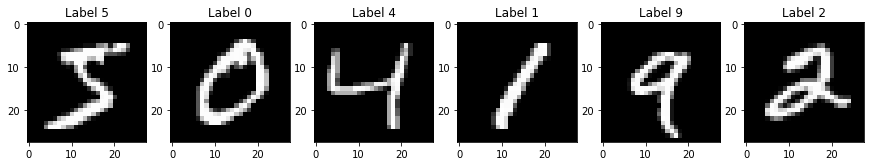

In [18]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = train_dataset[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target.item()))

## Tensor's definition on the GPU 
The first step is detecting if a GPU unit is installed, if not, the CPU is used instead (variable: device).
Each tensor is assigned to the device and the gradient option is activated for the optimization process. Tensors created are: weight(w) and bias(b) defined to compute the linear perceptron function, Y = XW + b. Both are randomly initialized.

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = torch.randn(28*28, 10, dtype=dtype, requires_grad=True, device=device)
b = torch.randn(10, dtype=dtype, requires_grad=True, device=device)

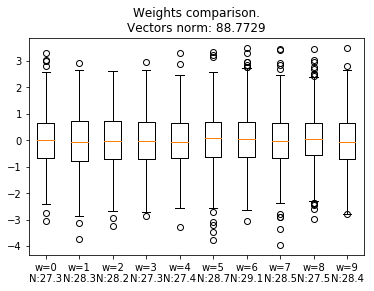

In [55]:
display_weights()

The weight distribution of each perceptron unit is presented in the figure. Since they were randomly initialized, their distributions are pretty symmetric, centered in zero. Another representation of this random initialization is presented in the figures below, where no patterns are observed in the weights of each computational unit.

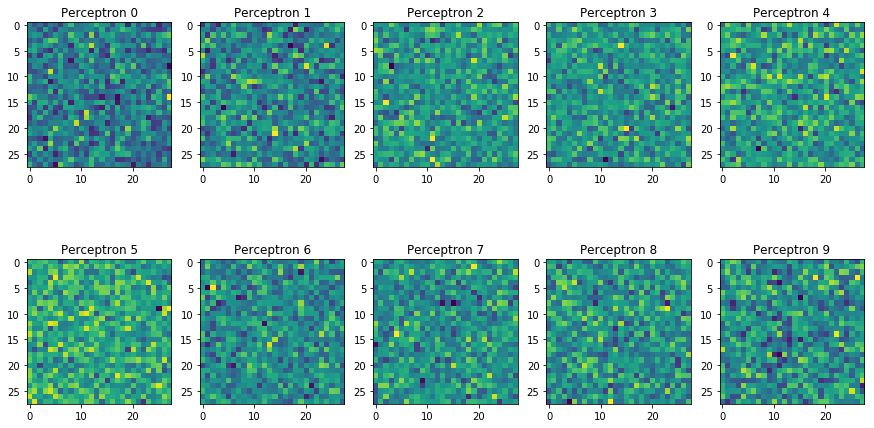

In [56]:
weights_image_display()

## Model training
The intention of this experiment is to illustrate the backpropagation method in a one layer perceptron based on one tensor. Hence, the linear function wx+b is used as input to the softmax function to get the probability of each label identification. 

The loss function used in this case is the cross-entropy. It was implemented step by step in order to review the interaction process between the CPU and the GPU unit. The target label was transformed into a one-hot vector to use the vector multiplication between the log of the probability and the target label.

An important limitation observed is the impossibility of torch in controlling the backpropagation error in the gradient matrix for small probabilities in the initial steps of the training process. Which mean, the weights updating step w = w + rate * grad of w is not applicable directly, since the entire gradient matrix is nan when predicting probabilities are small. This error is controlled by the torch.optim.SGD function. 

In [58]:
softmax = nn.Softmax(dim=0)
optimizer = torch.optim.SGD([weights, b], lr=learning_rate)

metrics = pd.DataFrame(columns=['epoch', 'loss', 'w_gradient', 'accuracy'])

for epoch in range(num_epochs):
    gradient_norm, loss_value, batch_size_temp = 0, 0, batch_size
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        if data.size()[0] != batch_size:
            batch_size_temp = data.size()[0]
            
        # Softmax of the linear perceptron output:
        y_pred = softmax(data.mm(weights) + b).to(device)
        
        # One-hot vector definition:
        y = torch.zeros(10, batch_size_temp).to(device)
        j = torch.arange(batch_size_temp).to(device)
        y[target, j] = 1
        
        # Crossentropy loss function:
        loss = (-torch.sum(torch.log(torch.diag(torch.mm(y_pred, y))))).to(device)
        
        # Backpropagation step:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_value += loss.item()
        gradient_norm += weights.grad.data.norm().item()
        
    batch_size_temp = batch_size
    total_labels, total_correct = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        if data.size()[0] != batch_size:
            batch_size_temp = data.size()[0]
        y_pred = torch.max(softmax(data.mm(weights) + b), 1)
        total_correct += (target == y_pred[1]).sum().item()
        total_labels += data.size()[0]

    d = {'epoch': epoch, 'loss': loss_value/(batch_size*len(train_loader)), 
         'w_gradient': gradient_norm/len(train_loader), 'accuracy': 100*total_correct/total_labels}
    metrics = metrics.append(d, ignore_index=True)
    if epoch % 5 == 0 or epoch == (num_epochs-1):
        print('epoch: {}, Loss function: {:,.4f}, Average gradient norm: {:,.4f}, test accuracy: {:,.2f}%'.format(d['epoch']+1, d['loss'], d['w_gradient'], d['accuracy']))
print('Training process finish...')

epoch: 1, Loss function: 3.9830, Average gradient norm: 74.0828, test accuracy: 79.00%
epoch: 6, Loss function: 2.5005, Average gradient norm: 37.4536, test accuracy: 87.00%
epoch: 11, Loss function: 2.4548, Average gradient norm: 35.2294, test accuracy: 88.00%
epoch: 16, Loss function: 2.4418, Average gradient norm: 34.6126, test accuracy: 88.00%
epoch: 21, Loss function: 2.4357, Average gradient norm: 34.3358, test accuracy: 88.00%
epoch: 26, Loss function: 2.4321, Average gradient norm: 34.1775, test accuracy: 88.00%
epoch: 31, Loss function: 2.4296, Average gradient norm: 34.0736, test accuracy: 88.00%
epoch: 36, Loss function: 2.4279, Average gradient norm: 33.9995, test accuracy: 89.00%
epoch: 41, Loss function: 2.4265, Average gradient norm: 33.9437, test accuracy: 89.00%
epoch: 46, Loss function: 2.4254, Average gradient norm: 33.9001, test accuracy: 89.00%
epoch: 51, Loss function: 2.4245, Average gradient norm: 33.8650, test accuracy: 89.00%
epoch: 56, Loss function: 2.4237, 

## Training results

Text(0.5,1,'Loss function')

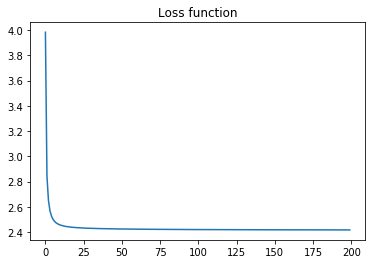

In [59]:
plt.plot('epoch', 'loss', data=metrics)
plt.title('Loss function')

Text(0.5,1,'Weights gradient norm')

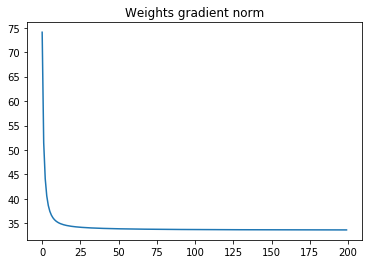

In [60]:
plt.plot('epoch', 'w_gradient', data=metrics)
plt.title('Weights gradient norm')

Text(0.5,1,'Data test accuracy')

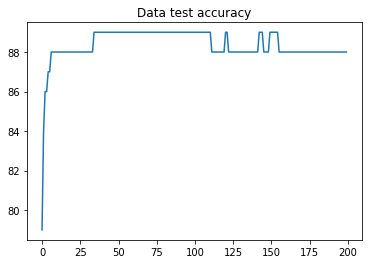

In [61]:
plt.plot('epoch', 'accuracy', data=metrics)
plt.title('Data test accuracy')

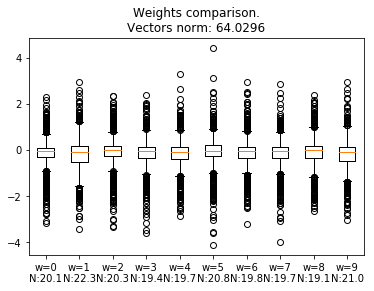

In [62]:
display_weights()

The weights distributions are still symmetric, however, 50% are closer than zero while the remaining values are larger in absolute value due to the training process. This is confirmed by the above figure, where some patterns are presented, which mean that weights are not random.

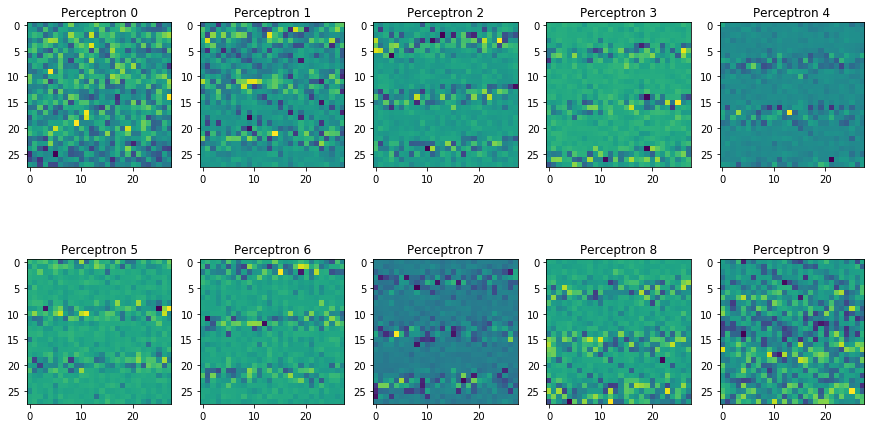

In [67]:
weights_image_display()

## Some errors examples

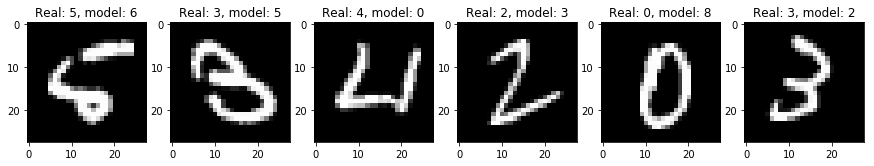

In [131]:
batch_size_temp = batch_size
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.view(-1, 784).to(device)
    target = target.to(device)
    if data.size()[0] != batch_size:
        batch_size_temp = data.size()[0]
    y_pred = torch.max(softmax(data.mm(weights) + b), 1)
    errors = y_pred[1]!=target
    predic_labels = y_pred[1][errors]
    error_images = data[errors, :]
    fig = plt.figure(figsize=(15, 8))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        sample_image = error_images[i, :].cpu()
        sample_image = sample_image.view(28, 28).numpy()
        sample_target = predic_labels[i].item()
        plt.imshow(sample_image, cmap='gray')
        plt.title('Real: {}, model: {}'.format(target[errors][i].item(), sample_target))
    if len(errors)>5:
        break
        

In [ ]:
batch_size_temp = batch_size
total_labels, total_correct = 0, 0
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.view(-1, 784).to(device)
    target = target.to(device)
    if data.size()[0] != batch_size:
        batch_size_temp = data.size()[0]
    y_pred = torch.max(softmax(data.mm(weights) + b), 1)
    errors = target != y_pred[1]
    total_labels += data.size()[0]

## GPU use during the training process

![GPU%20use.jpg](attachment:https://github.com/henrychacon/IS7033---MNIST-intro-Torch/blob/master/GPU%20use.jpg)
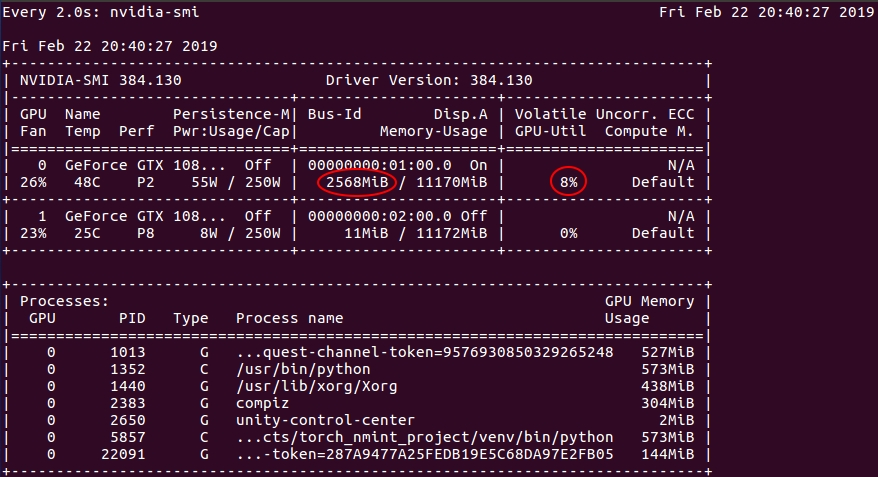